In [1]:
print(1)


1


### ML methods

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

import sys
sys.path.append("../scripts/")
from dataset import load_sara
from preprocess_sara import full_preproc

/scratch/2469038g/miniconda3/envs/ryanenv2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def ml_tech(train ,test):
    vectorizer = CountVectorizer()
    vectorizer.fit(train.text.tolist())
    train_features = vectorizer.transform(train.text.tolist())
    test_features = vectorizer.transform(test.text.tolist())
    train_labels = train.sensitivity
    test_labels = test.sensitivity

    dummy_mf = DummyClassifier(strategy="most_frequent")
    dummy_mf.fit(train_features, train_labels)
    mf_preds = dummy_mf.predict(test_features)
    #evaluation_summary("Dummy MF", test_labels, mf_preds)

    dummy_rand = DummyClassifier(strategy="stratified")
    dummy_rand.fit(train_features, train_labels)
    rand_preds = dummy_rand.predict(test_features)
    #evaluation_summary("Dummy Random stratified sampling", test_labels, rand_preds)


    tfidf_vectoizer = TfidfVectorizer()
    train_tfidf = tfidf_vectoizer.fit_transform(train.text.tolist())
    test_tfidf = tfidf_vectoizer.transform(test.text.tolist())

    lr = LogisticRegression(max_iter=500)
    lr.fit(train_tfidf, train.sensitivity)
    lr_preds = lr.predict(test_tfidf)
    #evaluation_summary("LR", test.sensitivity, lr_preds)

    svm_model = SVC()
    svm_model.fit(train_tfidf, train.sensitivity)
    svm_preds = svm_model.predict(test_tfidf)
    #evaluation_summary("SVM", test.sensitivity, svm_preds)

    return mf_preds, rand_preds, lr_preds, svm_preds

## MAIN

In [4]:
import ir_datasets
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, fbeta_score
from config import *
import re
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split


In [5]:
def get_sara():
    return ir_datasets.load('sara')

def dataset_to_df(sara_dataset):
    doc_ids = []
    doc_text = []
    doc_sens = []
    for doc in sara_dataset.docs_iter():
        doc_ids.append(doc.doc_id)
        doc_text.append(doc.text)
        doc_sens.append(doc.sensitivity)

    sara_dict = {'doc_id':doc_ids, 'text':doc_text, 'sensitivity':doc_sens}
    df = pd.DataFrame.from_dict(sara_dict)
    return df

def get_sample_n(data, n):
    return data.sample(n=n, random_state=1)

def get_sample_frac(data, frac):
    return data.sample(frac=frac, random_state=1)


def evaluation_summary(description, true_labels, predictions):
    target_classes = ['Non-sensitive (0)', 'Sensitive (1)']
    print("Evaluation for: " + description)
    print(classification_report(true_labels, predictions, digits=3, zero_division=0, target_names=target_classes))
    print('\n\nConfusion matrix:')
    confusionMatrix = confusion_matrix(true_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix, display_labels=target_classes) 
    disp.plot()
    plt.show()

def tpr(labels, preds):
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    tpr = tp / (tp+fn)
    return tpr

def tnr(labels, preds):
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    tnr = tn / (tn+fp)
    return tnr

#def auroc(group):
#    return roc_auc_score(group['ground_truth'], group['prediction'])

def get_metric_dict(method, labels, preds):
    acc = accuracy_score(labels, preds)
    bac = balanced_accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='binary')
    prec = precision_score(labels, preds, average='binary')
    rec = recall_score(labels, preds, average='binary')
    f2 = fbeta_score(labels, preds, average='binary', beta=2)
    tpr_score = tpr(labels, preds)
    tnr_score = tnr(labels, preds)
    metric_dict = {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1_score': f1, 'bal accuracy': bac, 'f2_score': f2, 'tpr':tpr_score, 'tnr':tnr_score}
    return metric_dict
    metrics_data[method] = metric_dict

In [6]:
import email
import gensim

def no_reply_proc(s, tokenizer='', c_size=2048):
    def preprocess(e):
        message = email.message_from_string(e)
        clean = message.get_payload()
        clean = re.sub('\S*@\S*\s?', '', clean)
        clean = re.sub('\s+', ' ', clean)
        clean = re.sub("\'", "", clean)
        clean = gensim.utils.simple_preprocess(str(clean), deacc=True, min_len=1, max_len=100) 
        return clean

    def remove_doubles(df):
        already_exists = []
        unique_df = []
        for i, s in enumerate(df.iterrows()):
            idd = s[1].doc_id
            text = s[1].text
            sensitivity = s[1].sensitivity
            if text in already_exists:
                continue
            already_exists.append(text)
            unique_df.append({'doc_id': idd, 'text':text, 'sensitivity':sensitivity})    
        return pd.DataFrame.from_dict(unique_df)

    def main(s):
        processed_emails = [preprocess(a) for a in s.text]
        ids = s.doc_id.tolist()
        sens = s.sensitivity.tolist()
        texts = []
        for i, text in enumerate(s.text):
            new_email = ' '.join(processed_emails[i])
            texts.append(new_email)

        new_dict = {'doc_id': ids, 'text': texts, 'sensitivity':sens}
        preproc_df = pd.DataFrame.from_dict(new_dict)
        preproc_df = remove_doubles(preproc_df)
        return preproc_df

    return main(s)

In [9]:
def main_experiment():
    sara_dataset = get_sara()
    sara_df = dataset_to_df(sara_dataset)
    sara_df = no_reply_proc(sara_df)
    train = sara_df
    svmatch(train)

main_experiment()

{'accuracy': 0.8904761904761904, 'precision': 0.9166666666666666, 'recall': 0.07432432432432433, 'f1_score': 0.1375, 'bal accuracy': 0.5367125218743923, 'f2_score': 0.09105960264900663, 'tpr': 0.07432432432432433, 'tnr': 0.9991007194244604}


In [8]:
def svmatch(data):
    #print(data.head())
    X = data.text.to_numpy()
    y = data.sensitivity.to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)


    tfidf_vectoizer = TfidfVectorizer()
    train_tfidf = tfidf_vectoizer.fit_transform(X_train)
    test_tfidf = tfidf_vectoizer.transform(X_test)

    svm_model = SVC()
    svm_model.fit(train_tfidf, y_train)
    svm_preds = svm_model.predict(test_tfidf)
    #print(svm_preds)
    print(get_metric_dict('SVMMATCH', y_test, svm_preds))
    
mr = main_experiment()

{'accuracy': 0.8801587301587301, 'precision': 0.9, 'recall': 0.05660377358490566, 'f1_score': 0.10650887573964497, 'bal accuracy': 0.5278477541857317, 'f2_score': 0.0696594427244582, 'tpr': 0.05660377358490566, 'tnr': 0.9990917347865577}


{'accuracy': 0.7253968253968254, 'precision': 0.22284122562674094, 'recall': 0.54421768707483, 'f1_score': 0.31620553359683795, 'bal accuracy': 0.6467719163136953, 'f2_score': 0.4223864836325238, 'tpr': 0.54421768707483, 'tnr': 0.7493261455525606}
Evaluation for: SVM
                   precision    recall  f1-score   support

Non-sensitive (0)      0.926     0.749     0.828      1113
    Sensitive (1)      0.223     0.544     0.316       147

         accuracy                          0.725      1260
        macro avg      0.574     0.647     0.572      1260
     weighted avg      0.844     0.725     0.768      1260



Confusion matrix:


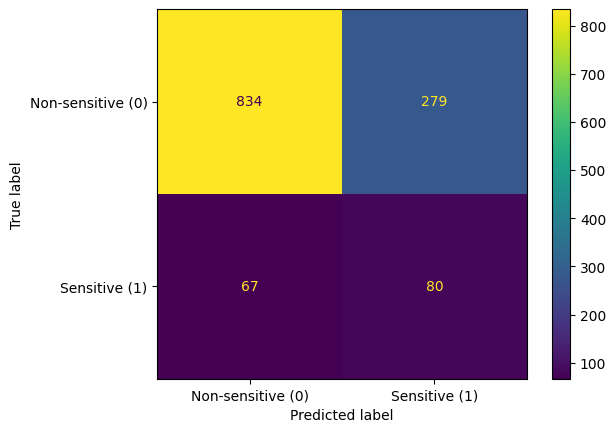

In [10]:
def cat(text):
    l = text.split('\r\n\r\n')
    return l[1]

def svmatch(data):
    np.random.seed(1)
    #print(data.head())

    #data['text'] = data['text'].apply(cat)
    #data = data[data.text.str.len() < 11000]
    
    X = data.text.to_numpy()
    y = data.sensitivity.to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=2)

    majority_class_index = np.where(y_train == 0)[0]
    minority_class_index = np.where(y_train == 1)[0]
    downsampled_majority_index = np.random.choice(majority_class_index, size=len(minority_class_index), replace=False)
    combined_indices = np.concatenate([downsampled_majority_index, minority_class_index])
    X_train = X_train[combined_indices]
    y_train = y_train[combined_indices]

    tfidf_vectoizer = TfidfVectorizer()
    train_tfidf = tfidf_vectoizer.fit_transform(X_train)
    test_tfidf = tfidf_vectoizer.transform(X_test)

    svm_model = SVC()
    svm_model.fit(train_tfidf, y_train)
    svm_preds = svm_model.predict(test_tfidf)
    #print(svm_preds)
    print(get_metric_dict('SVMMATCH', y_test, svm_preds))
    evaluation_summary('SVM', y_test, svm_preds)
    
mr = main_experiment()
    

In [11]:
np.random.seed(1)


In [12]:
def get_set():
    sara_dataset = get_sara()
    sara_df = dataset_to_df(sara_dataset)
    sara_df = no_reply_proc(sara_df)
    train = sara_df
    return train


In [13]:
data = get_set()
X = data.doc_id.to_numpy()
y = data.sensitivity.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=1)

In [14]:
X_train

array(['54587', '173893', '173960', '173215', '176509', '234551',
       '175198', '173152', '52993', '128209', '174244', '173842',
       '175706', '176539', '176727', '177826', '175380', '10425',
       '175839', '173154', '174112', '125520', '175143', '54542', '70706',
       '175841', '176689', '173169', '173139', '127099', '230395',
       '44727', '129665', '121903', '173163', '52167', '175197', '174320',
       '173143', '136409', '175609', '121219', '176927', '178056',
       '175619', '54583', '175846', '175336', '175675', '1825', '52555',
       '54526', '175281', '151121', '9210', '174341', '175306', '174361',
       '175671', '174388', '174302', '174374', '136198', '54619',
       '174512', '54607', '173920', '175542', '123650', '175788', '54657',
       '174242', '176661', '176695', '54676', '175689', '136392',
       '173538', '175475', '175314', '173354', '176751', '173804',
       '219530', '175617', '54588', '7932', '47174', '176685', '175816',
       '175353', '173279

In [15]:
len(X_train)

314